# Loan Default Risk Prediction
This notebook presents an optimized workflow for building a model that predicts the likelihood of borrowers defaulting on loans using customer data. By identifying high-risk applicants early, financial institutions can make informed lending decisions, reduce credit losses, and optimize portfolio performance.

### Table of Contents
1.  Import Libraries
2.  Load the Dataset
3.  Exploratory Data Analysis (EDA)
4.  Preprocessing
5.  Principal Component Analysis (PCA)
6.  Model Training and Evaluation

### 1. Import Libraries
This section imports necessary libraries and is subsectioned by function. Using `sns.set_style('whitegrid')` ensures consistent, professional visualization aesthetics.

#### Data handling and visualization

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

#### Feature optimization, model building and evaluation

In [53]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn import show_versions
import joblib 

### 2. Load the Dataset
This dataset has been taken from **[Coursera's Loan Default Prediction Challenge deposited in Kaggle](https://www.kaggle.com/datasets/nikhil1e9/loan-default)**. It comprises **255,347 entries** with **18 columns**, including numerical and categorical features, and the binary target `Default`. Columns names and descriptions are outlined below:
- `LoanID` - A unique identifier for each loan
- `Age` - The age of the borrower
- `Income` - The annual income of the borrower
- `LoanAmount` - The amount of money being borrowed
- `CreditScore` - The credit score of the borrower
- `MonthsEmployed` - The number of months the borrower has been employed
- `NumCreditLines` - The number of credit lines the borrower has open
- `InterestRate` - The interest rate for the loan
- `LoanTerm` - The term length of the loan in months
- `DTIRatio` - The Debt-to-Income ratio
- `Education` - The highest level of education attained by the borrower
- `EmploymentType` - The type of employment status of the borrower
- `MaritalStatus` - The marital status of the borrower
- `HasMortgage` - Whether the borrower has a mortgage
- `HasDependents` - Whether the borrower has dependents
- `LoanPurpose` - The purpose of the loan
- `HasCoSigner` - Whether the loan has a co-signer
- `Default` - Indicate whether the loan defaulted or not

No missing values are present. 

#### Read data

In [54]:
dtype_dict = {
    'Age': 'int32',
    'Income': 'int32',
    'LoanAmount': 'int32',
    'CreditScore': 'int32',
    'MonthsEmployed': 'int32',
    'NumCreditLines': 'int32',
    'InterestRate': 'float32',
    'LoanTerm': 'int32',
    'DTIRatio': 'float32',
    'Default': 'int32'
}

raw_data = pd.read_csv('Loan_Default_Dataset.csv', dtype=dtype_dict)

#### Inspect structure and contents

In [55]:
raw_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int32  
 2   Income          255347 non-null  int32  
 3   LoanAmount      255347 non-null  int32  
 4   CreditScore     255347 non-null  int32  
 5   MonthsEmployed  255347 non-null  int32  
 6   NumCreditLines  255347 non-null  int32  
 7   InterestRate    255347 non-null  float32
 8   LoanTerm        255347 non-null  int32  
 9   DTIRatio        255347 non-null  float32
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

#### Inspect continuous variables

In [56]:
raw_data.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


### 3. Exploratory Data Analysis (EDA)
Duplicate check confirms no duplicates, preserving dataset integrity. Outlier removal via IQR method is applied to continuous features to mitigate skew; however, based on descriptive statistics, no data points fall outside **1.5 * IQR** bounds for any variable, so the dataset size remains unchanged. Visualizations use percentages for categorical balance and histograms for continuous spread, aiding in detecting imbalances. As expected, `Default` is imbalanced at only **~11.6% positive**.

#### Check for missing values

In [57]:
duplicates = raw_data.duplicated().sum()
print(duplicates)
raw_data = raw_data.drop_duplicates()

0


#### Outlier detection and removal using IQR

In [58]:
continuous_cols = raw_data.drop(columns=['Default']).select_dtypes(include='number').columns
for col in continuous_cols:
    Q1 = raw_data[col].quantile(0.25)
    Q3 = raw_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    raw_data = raw_data[(raw_data[col] >= lower_bound) & (raw_data[col] <= upper_bound)]

#### Target variable distribution

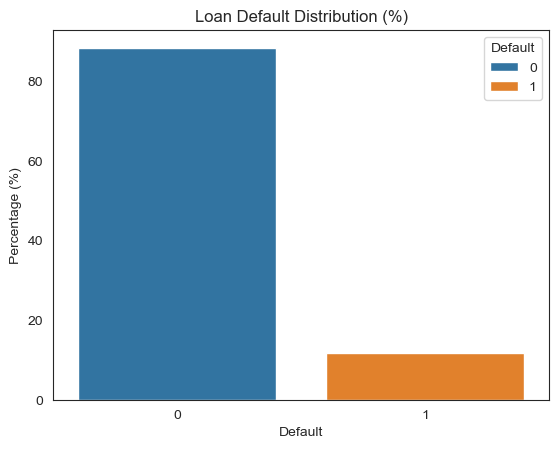

In [59]:
def plot_percentage_bar(df, col, title, hue=None):
    '''
    Plot bar chart of percentage distribution.
    
    Parameters:
    - df: DataFrame
    - col: Column name
    - title: Plot title
    - hue: Optional hue for grouping
    '''
    percentages = df[col].value_counts(normalize=True).reset_index()
    percentages.columns = [col, 'Percentage']
    percentages['Percentage'] *= 100
    sns.barplot(x=col, y='Percentage', data=percentages, hue=hue or col)
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.show()

plot_percentage_bar(raw_data, 'Default', 'Loan Default Distribution (%)')

#### Categorical feature distributions

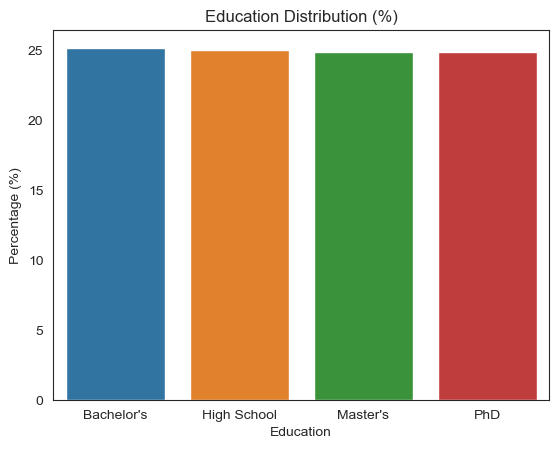

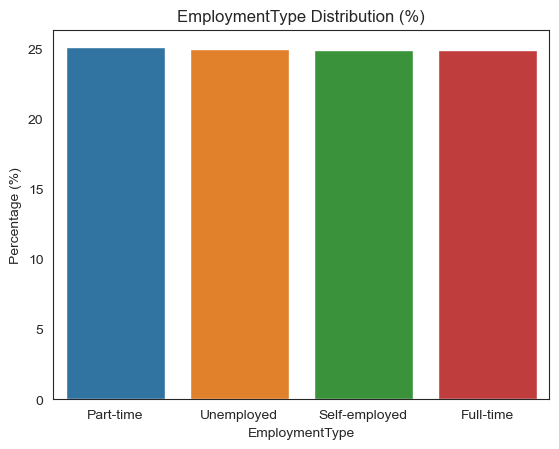

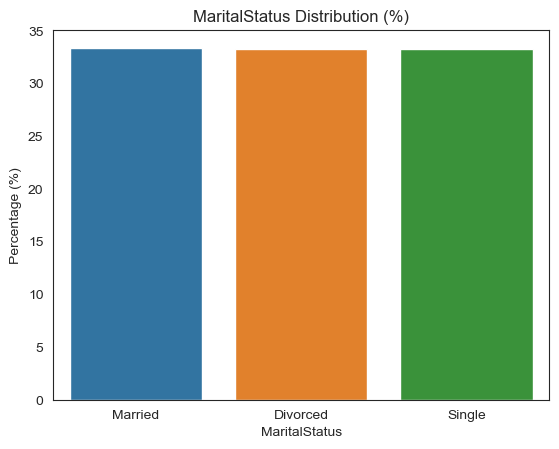

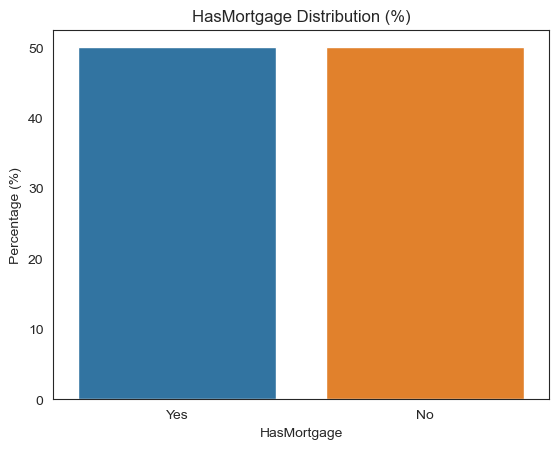

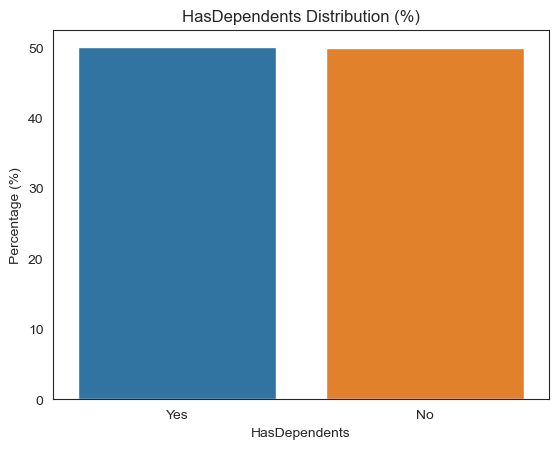

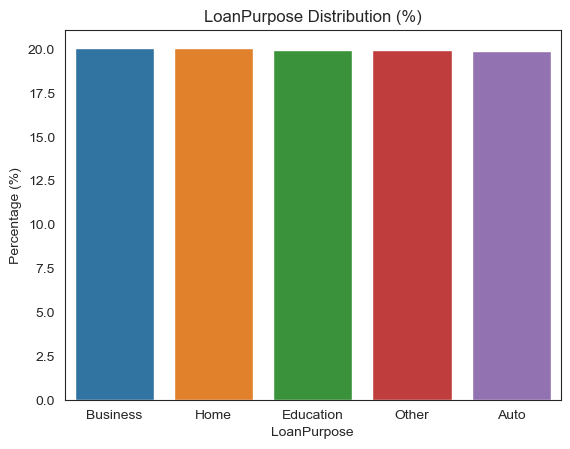

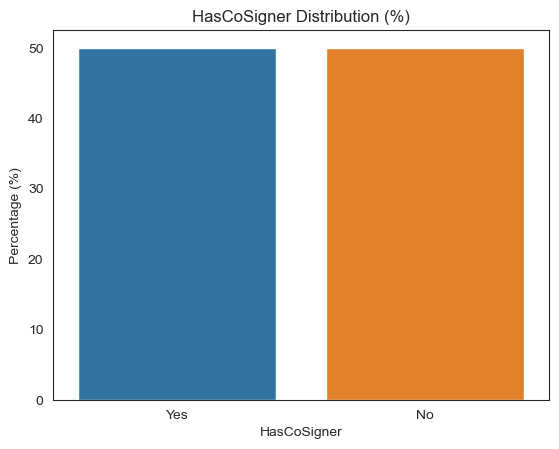

In [60]:
categorical_cols = raw_data.drop(columns=['LoanID']).select_dtypes(include=['object']).columns
for col in categorical_cols:
    plot_percentage_bar(raw_data, col, f'{col} Distribution (%)')

#### Continuous feature distributions

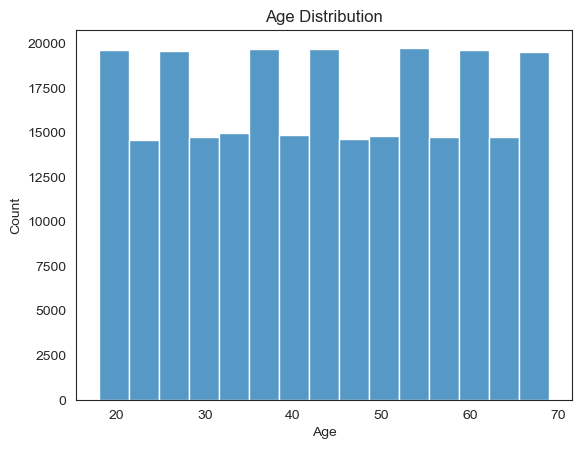

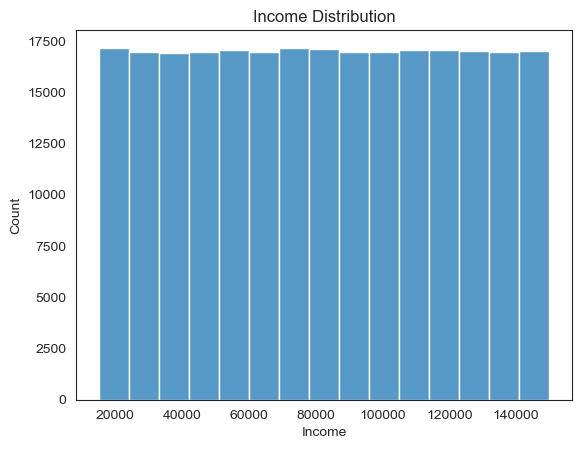

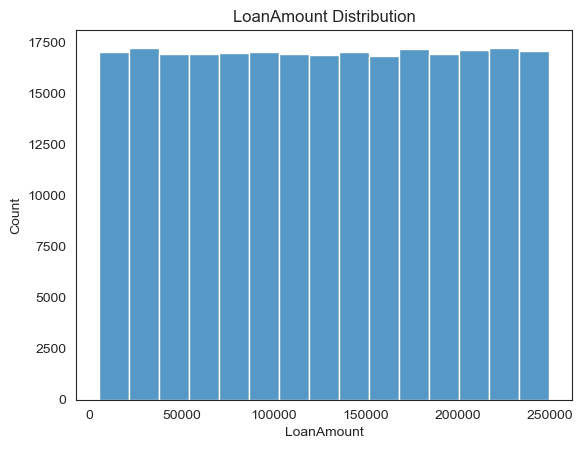

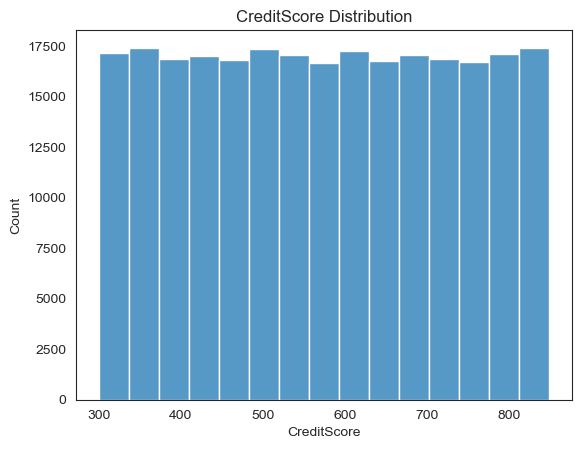

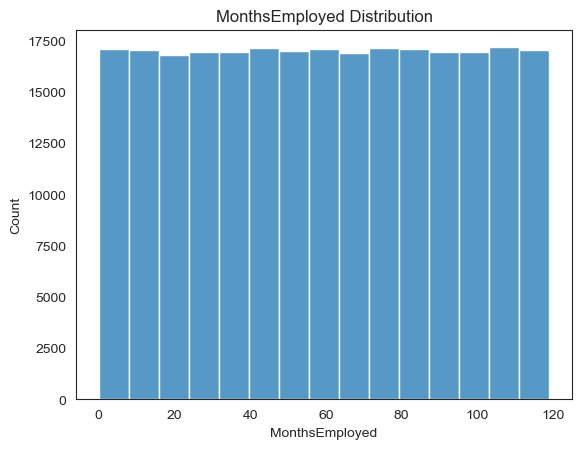

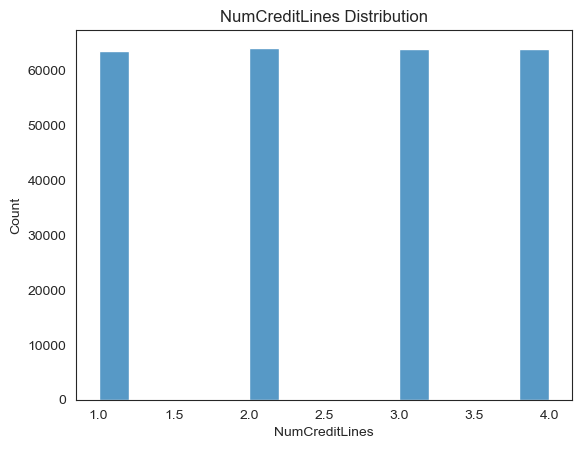

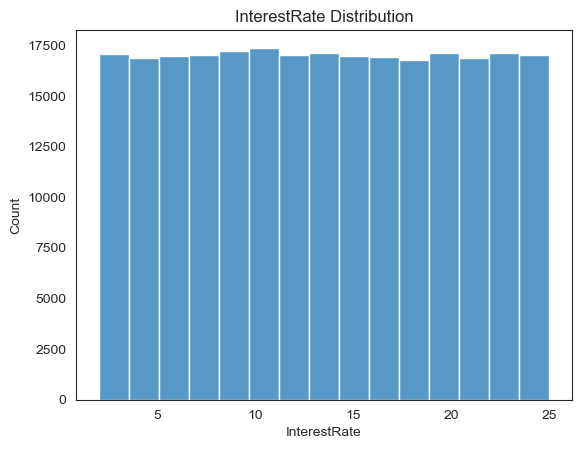

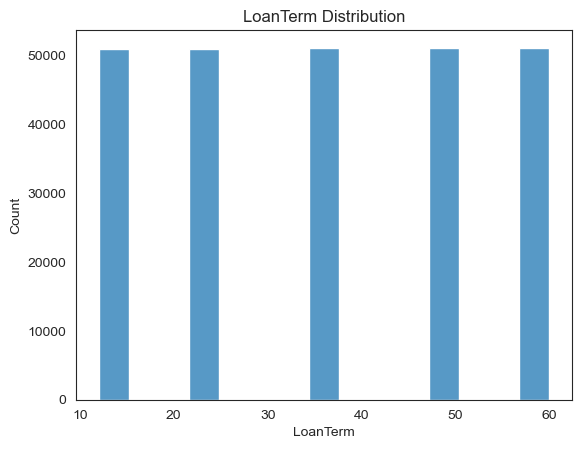

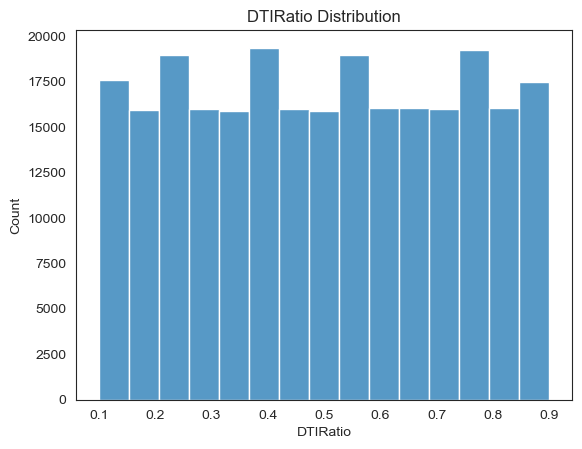

In [61]:
continuous_cols = raw_data.drop(columns=['Default']).select_dtypes(include='number').columns
for col in continuous_cols:
    sns.histplot(x=col, data=raw_data, bins=15, kde=False)
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

### 4. Preprocessing
Preprocessing encodes categorical variables ordinally, assuming inherent order (e.g., **High School** < **Bachelor's** < **Master's** < **PhD**). Correlation heatmap assays feature relationships. No strong multicollinearity is evident from the provided output, supporting model assumptions.

#### Encode categorical variables
##### Create encoder

In [62]:
# Define ordinal mappings
education_order = ['High School', 'Bachelor\'s', 'Master\'s', 'PhD']
employment_order = ['Unemployed', 'Part-time', 'Self-employed', 'Full-time']
marital_order = ['Divorced', 'Single', 'Married']
binary_order = ['No', 'Yes']  
loan_purpose_order = ['Business', 'Education', 'Other', 'Home', 'Auto']

# Encoders
encoders = {
    'Education': OrdinalEncoder(categories=[education_order]),
    'EmploymentType': OrdinalEncoder(categories=[employment_order]),
    'MaritalStatus': OrdinalEncoder(categories=[marital_order]),
    'HasMortgage': OrdinalEncoder(categories=[binary_order]),
    'HasDependents': OrdinalEncoder(categories=[binary_order[::-1]]), 
    'LoanPurpose': OrdinalEncoder(categories=[loan_purpose_order]),
    'HasCoSigner': OrdinalEncoder(categories=[binary_order])
}

##### Function to apply encodings

In [63]:
def encode_data(df, encoders):
    '''
    Apply ordinal encoding to categorical columns.
    
    Parameters:
    - df: DataFrame
    - encoders: Dict of OrdinalEncoder instances
    
    Returns:
    - Encoded DataFrame
    '''
    df_encoded = df.copy()
    for col, enc in encoders.items():
        if col in df_encoded.columns:
            df_encoded[col] = enc.fit_transform(df_encoded[[col]])
    return df_encoded

##### Apply mappings

In [64]:
encoded_data = encode_data(raw_data.drop(columns=['LoanID']), encoders)
encoded_data.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,1.0,3.0,0.0,1.0,0.0,2.0,1.0,0
1,69,50432,124440,458,15,1,4.81,60,0.68,2.0,3.0,2.0,0.0,1.0,2.0,1.0,0
2,46,84208,129188,451,26,3,21.17,24,0.31,2.0,0.0,0.0,1.0,0.0,4.0,0.0,1
3,32,31713,44799,743,0,3,7.07,24,0.23,0.0,3.0,2.0,0.0,1.0,0.0,0.0,0
4,60,20437,9139,633,8,4,6.51,48,0.73,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0


#### Correlation heatmap of all variables

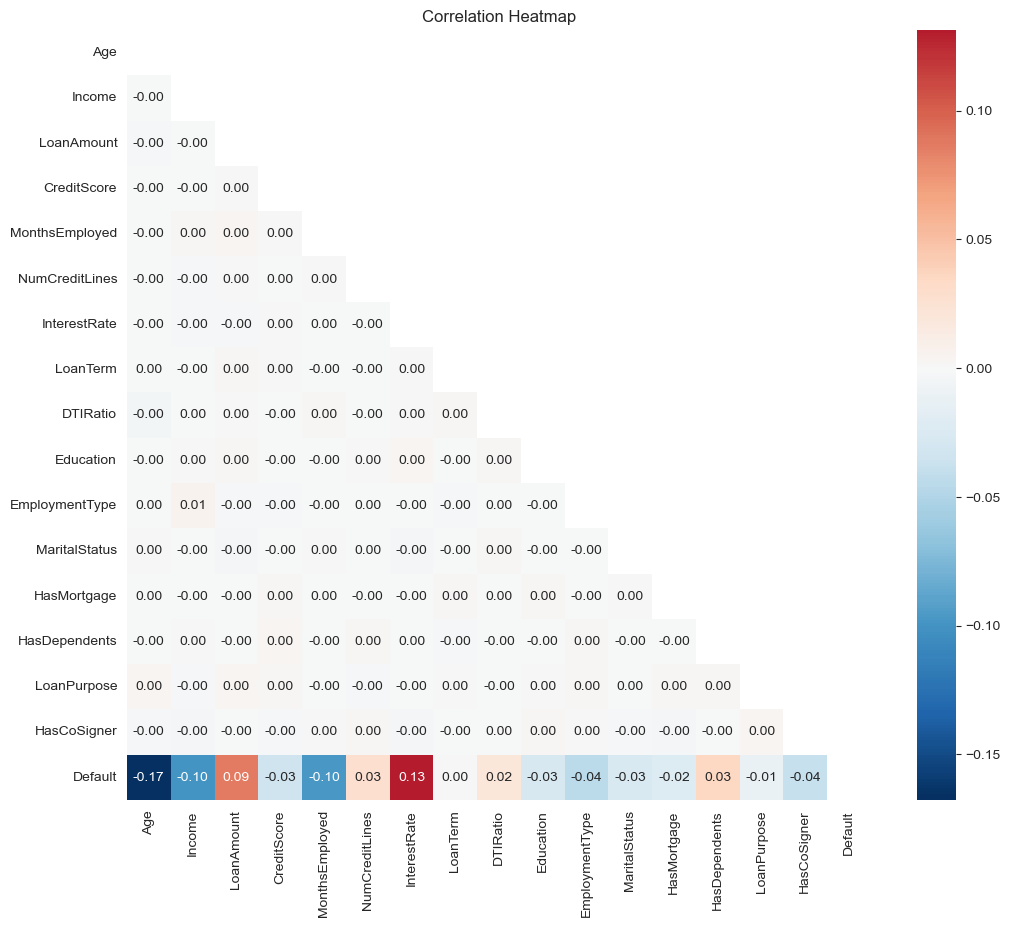

In [65]:
plt.figure(figsize=(12, 10))
corr_matrix = encoded_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', mask=mask, center=0)
plt.title('Correlation Heatmap')
plt.show()

#### Split features and target

In [66]:
X = encoded_data.drop(['Default'], axis=1)
y = encoded_data['Default'].values.astype(int)

### 5. Principal Component Analysis (PCA)
The threshold for 95% variance requires **16 components**, indicating low redundancy. Distributions of PCs by target class highlight separability.

#### Scale features (z-scores)

In [67]:
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=None))
])

X_pca = pca_pipeline.fit_transform(X)

# Check explained variance to justify n_components
explained_var = pca_pipeline.named_steps['pca'].explained_variance_ratio_
cum_var = np.cumsum(explained_var)
print('Cumulative Explained Variance:', cum_var)

# Set n_components to capture ~95% variance
n_comp = np.argmax(cum_var >= 0.95) + 1
print(f'Components for 95% variance: {n_comp}')

# Re-fit with optimal n_components
pca_pipeline.set_params(pca__n_components=n_comp)
components = pca_pipeline.fit_transform(X)
pca_df = pd.DataFrame(components, columns=[f'PC{i+1}' for i in range(n_comp)])

Cumulative Explained Variance: [0.0631707  0.12625972 0.18922817 0.25214215 0.31495654 0.37773625
 0.44039917 0.50296052 0.56541355 0.62781122 0.69017813 0.75236352
 0.81447736 0.87655045 0.93841992 1.        ]
Components for 95% variance: 16


#### Visualize PCs

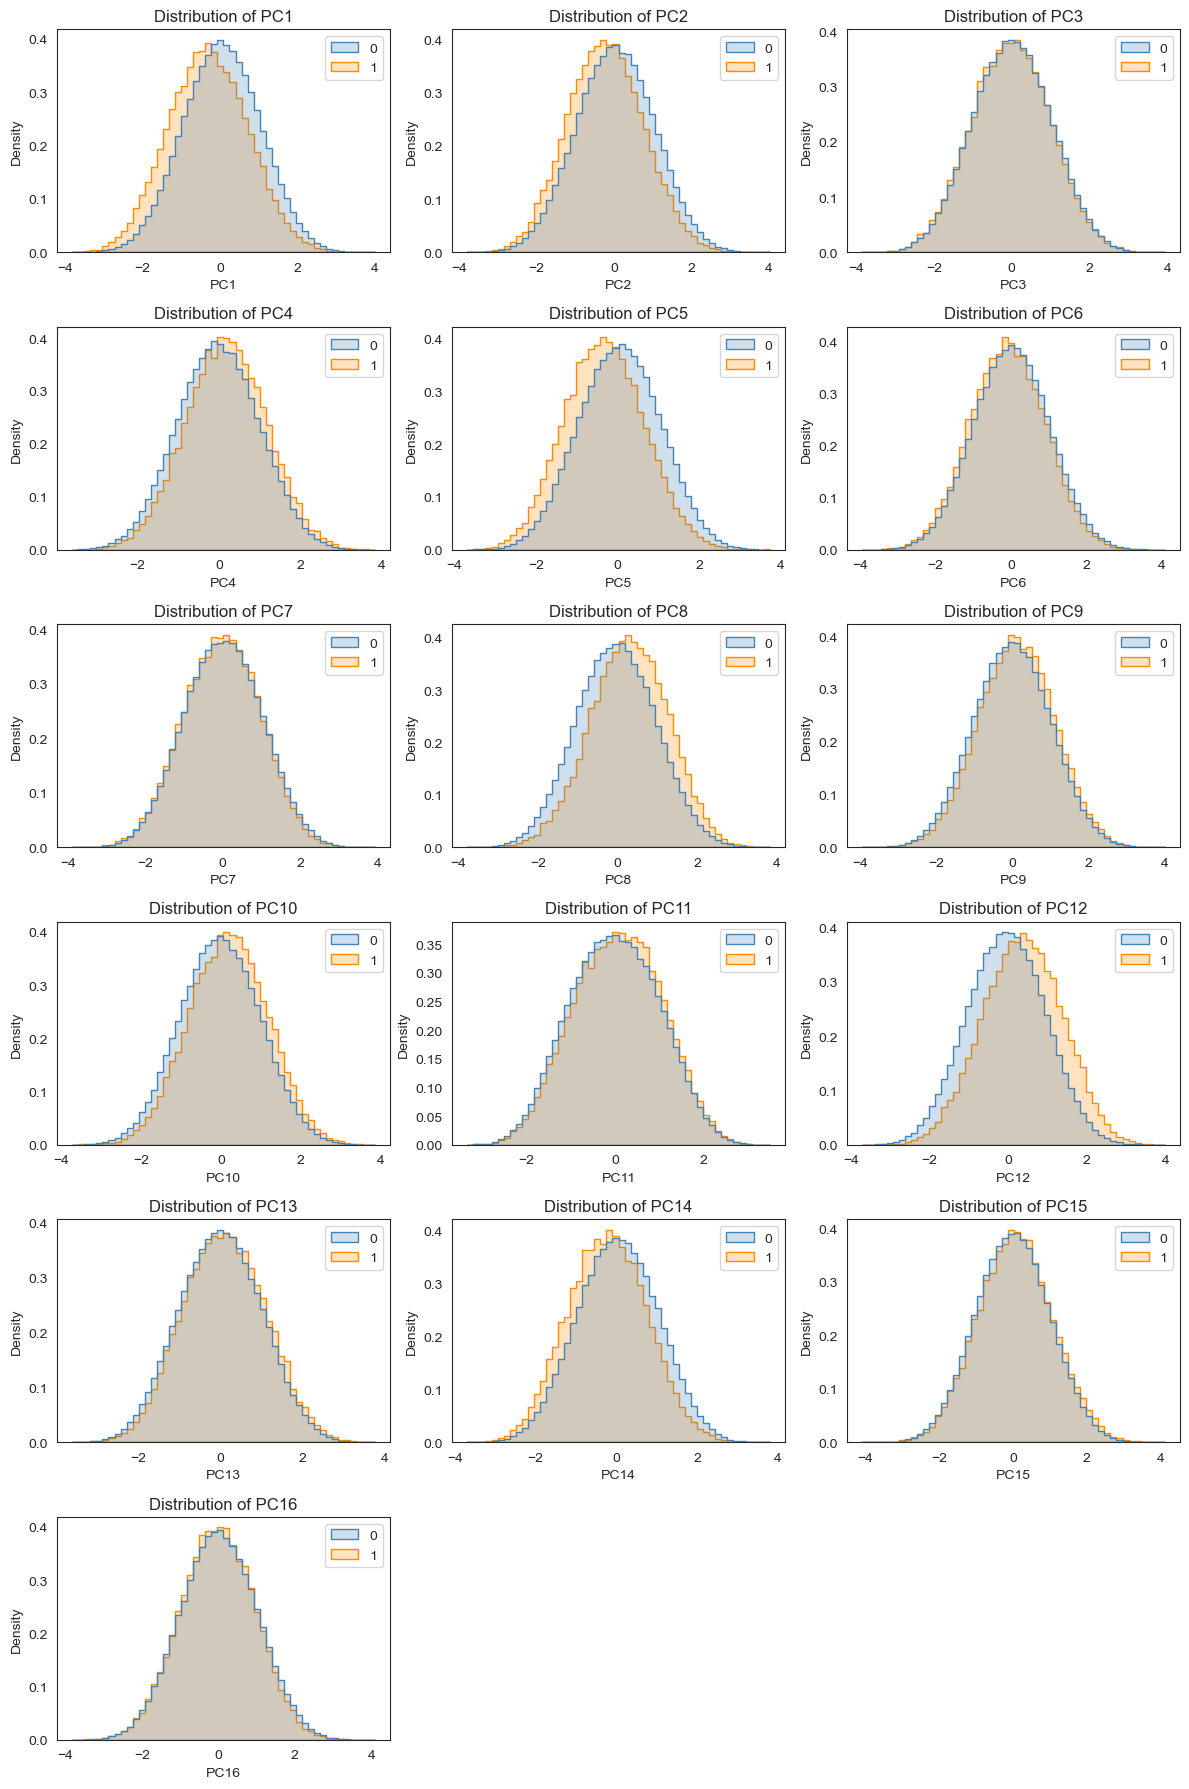

In [68]:
fig, axes = plt.subplots(6, 3, figsize=(12, 18)) if n_comp >= 6 else plt.subplots(1, n_comp, figsize=(4*n_comp, 4))

for i, ax in enumerate(axes.flat if n_comp > 1 else [axes], start=1):
    if i > n_comp:
        ax.axis('off')
        continue
    sns.histplot(
        data=pca_df,
        x=f'PC{i}',
        hue=y,
        bins=50,
        element='step',
        stat='density',
        common_norm=False,
        palette={0: 'steelblue', 1: 'darkorange'},
        ax=ax
    )
    ax.set_title(f'Distribution of PC{i}')
    ax.set_xlabel(f'PC{i}')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

#### Cache scaled data for modeling

In [69]:
joblib.dump(pca_pipeline.named_steps['scaler'].fit_transform(X), 'X_scaled.pkl')

['X_scaled.pkl']

### 6. Model Training and Evaluation
Models were trained with `class_weight='balanced'`, which effectively improved recall for the minority class without severely impacting overall precision. **5-fold cross-validation** showed consistent model performance across folds, indicating robust generalization. Average **ROC AUC** scores were: **Logistic Regression (0.752), Random Forest (0.752)**, and **Voting Classifier (0.757)**. Features contributing most to predictions included `Age`, `InterestRate`, `Income`, `MonthsEmplopyed`, and `LoanAmount`, highlighting key drivers of the target variable. The **Voting Classifier** and **Random Forest** models achieved minority **class recalls** of **0.68** and **0.71**, respectively, while maintaining **precisions** of **0.23** and **0.22**, demonstrating their ability to capture positive cases in an imbalanced target. Most errors were false positives for the minority class, suggesting potential areas for additional feature engineering to reduce overprediction.

#### Split train and test sets

In [70]:
X_scaled = joblib.load('X_scaled.pkl')  # Load cached scaled data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

#### Define evaluation function

In [71]:
def evaluate_model(model, X_test, y_test, title='Model'):
    '''
    Evaluate model with classification report, ROC curve, and confusion matrix.
    
    Parameters:
    - model: Fitted model
    - X_test: Test features
    - y_test: Test target
    - title: Model title for plots
    '''
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # ROC Curve
    y_scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.step(fpr, tpr, where='post', label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend()
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt=',', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

#### Logistic Regression

              precision    recall  f1-score   support

           0       0.95      0.67      0.79     45139
           1       0.22      0.71      0.34      5931

    accuracy                           0.68     51070
   macro avg       0.58      0.69      0.56     51070
weighted avg       0.86      0.68      0.73     51070



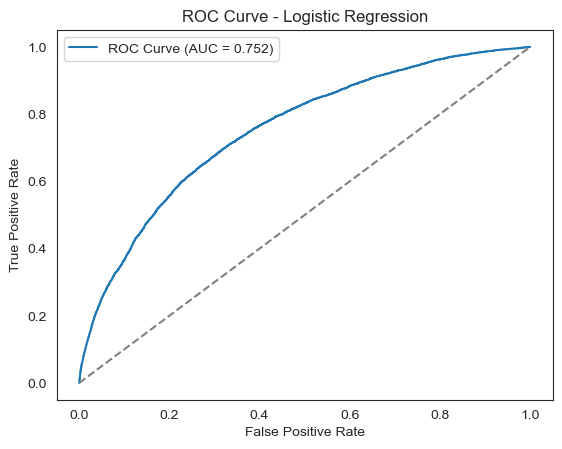

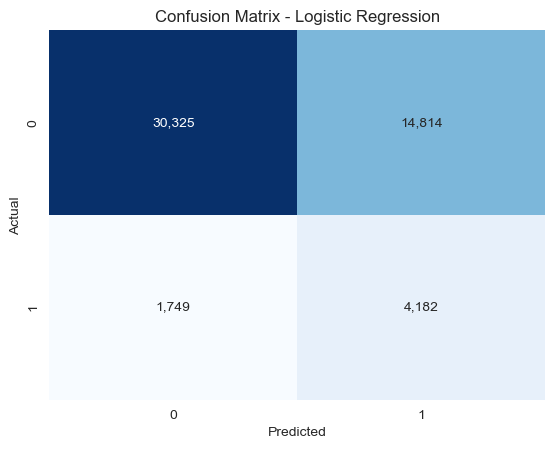

In [72]:
lr_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

cv = StratifiedKFold(n_splits=5)
grid_search_lr = GridSearchCV(lr_pipeline, param_grid={}, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

evaluate_model(grid_search_lr, X_test, y_test, 'Logistic Regression')

#### Random Forest

              precision    recall  f1-score   support

           0       0.94      0.74      0.83     45139
           1       0.24      0.63      0.35      5931

    accuracy                           0.73     51070
   macro avg       0.59      0.69      0.59     51070
weighted avg       0.86      0.73      0.77     51070



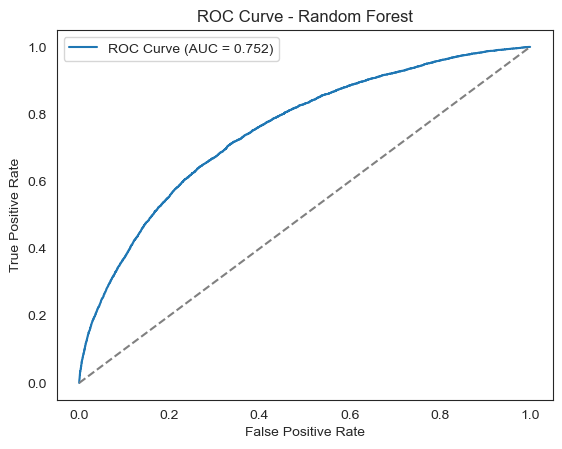

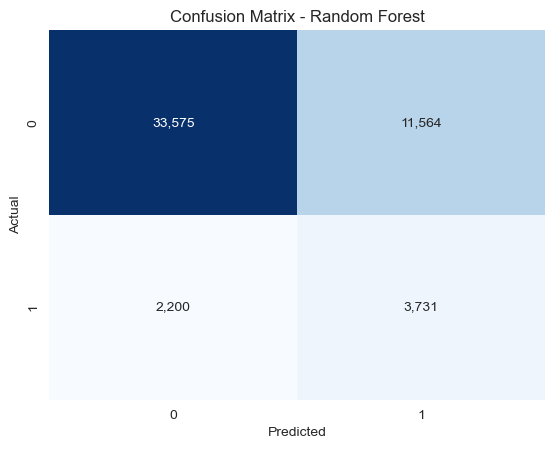

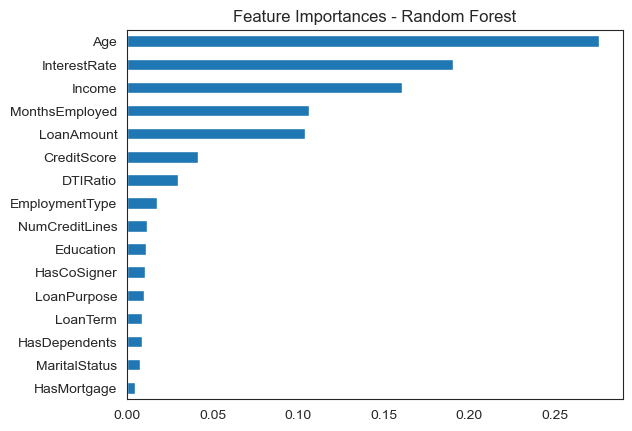

In [73]:
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

grid_search_rf = GridSearchCV(rf_pipeline, param_grid={}, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

evaluate_model(grid_search_rf, X_test, y_test, 'Random Forest')

# Feature Importances
importances = pd.Series(grid_search_rf.best_estimator_.named_steps['classifier'].feature_importances_, index=X.columns).sort_values()
importances.plot(kind='barh')
plt.title('Feature Importances - Random Forest')
plt.show()

#### Combined Model

              precision    recall  f1-score   support

           0       0.94      0.70      0.81     45139
           1       0.23      0.68      0.35      5931

    accuracy                           0.70     51070
   macro avg       0.59      0.69      0.58     51070
weighted avg       0.86      0.70      0.75     51070



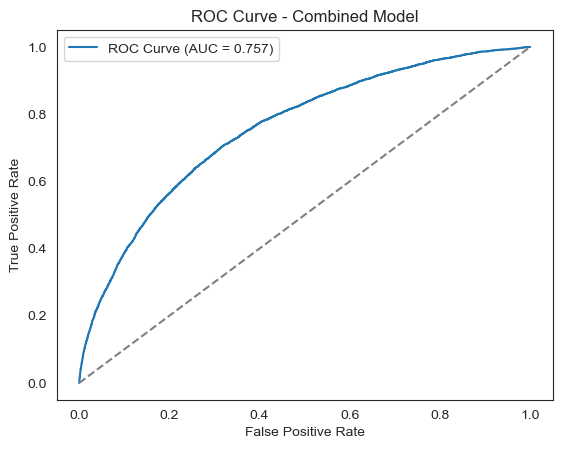

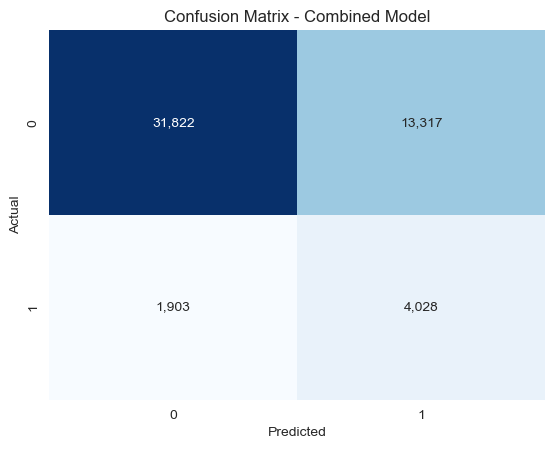

In [74]:
voting_clf = VotingClassifier(
    estimators=[('lr', grid_search_lr.best_estimator_), ('rf', grid_search_rf.best_estimator_)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)
evaluate_model(voting_clf, X_test, y_test, 'Combined Model')

### Environment Versions

In [75]:
show_versions()


System:
    python: 3.11.0 (heads/3.11-dirty:785b3676ef, Jan 18 2024, 18:53:12) [Clang 15.0.0 (clang-1500.1.0.2.5)]
executable: /private/var/containers/Bundle/Application/886DA911-9AD2-4750-B9D3-D777124926A3/Carnets-sci.app/Library/bin/pythonA
   machine: macOS-18.6-iPhone15,3-arm-64bit

Python dependencies:
      sklearn: 1.2.2
          pip: 23.3.2
   setuptools: 69.0.3
        numpy: 1.25.2+2.g530bd4c06
        scipy: 1.11.2
       Cython: 3.0.0
       pandas: 2.0.3
   matplotlib: 3.9.0.dev16+g5446a454e4
       joblib: 1.3.2
threadpoolctl: 3.2.0

Built with OpenMP: False
